# Spaceship Titanic Competition Notebook

In this notebook, we will work on the Spaceship Titanic competition. We will start with data exploration, then clean and process the data. We will try a few models: Logistic Regression, Random Forest, and finally, XGBoost with hyperparameter tuning. The goal is to build a robust pipeline and document each step of our process. 

Let’s get started.

## Data Loading and Preprocessing

We begin by loading the train and test datasets. Next, we define a function to clean the data and engineer features such as splitting cabin information, calculating total spending, and determining group size from the passenger IDs. The process function standardizes missing values and extracts useful features for our modeling.

In [36]:
import numpy as np
import pandas as pd

# Load the data
df = pd.read_csv('spaceship-titanic/train.csv')
test = pd.read_csv('spaceship-titanic/test.csv')

# Define a function to clean and process the data
def process_df(df0):
    # Process CryoSleep and VIP columns
    df0['CryoSleep'] = df0['CryoSleep'].apply(lambda x: False if pd.isnull(x) else (x.lower() == 'true' if isinstance(x, str) else x))
    df0['VIP'] = df0['VIP'].apply(lambda x: False if pd.isnull(x) else (x.lower() == 'true' if isinstance(x, str) else x))

    # Fill missing categorical fields
    df0['HomePlanet'] = df0['HomePlanet'].fillna('Unknown')
    df0['Destination'] = df0['Destination'].fillna('Unknown')
    df0['Name'] = df0['Name'].fillna('Unknown')

    # Fill missing numerical values for Age with the median of the dataset
    df0['Age'] = df0['Age'].fillna(df0['Age'].median())
    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df0[col] = df0[col].fillna(0)

    # Process Cabin: fill missing values and split into three parts
    df0['Cabin'] = df0['Cabin'].fillna("Unknown/0/Unknown")
    df0['CabinDeck'] = df0['Cabin'].str.split('/').str[0].astype('category')
    df0['CabinNum'] = df0['Cabin'].str.split('/').str[1].astype('category')
    df0['CabinSide'] = df0['Cabin'].str.split('/').str[2].astype('category')
    df0.drop('Cabin', axis=1, inplace=True)

    # Adjusted TotalSpending: weighted to reflect correlation with target
    df0['TotalSpending'] = (
        + df0['FoodCourt'] 
        + df0['ShoppingMall'] 
        + df0['RoomService'] 
        - df0['Spa'] 
        - df0['VRDeck']
    )

    # Extract group information from PassengerId
    df0['Group'] = df0['PassengerId'].str.split('_').str[0].astype('category')
    df0['NumberInGroup'] = df0['PassengerId'].str.split('_').str[1].astype('category')

    # Add new feature: TravelingAlone
    group_counts = df0['Group'].value_counts()
    df0['TravelingAlone'] = df0['Group'].map(group_counts) == 1

    # Drop unneeded columns
    df0 = df0.drop(columns=['PassengerId', 'Name'])

    return df0



# Process both training and test datasets
df = process_df(df)
test = process_df(test)

df['HomePlanet'] = df['HomePlanet'].astype('category')
df['CryoSleep'] = df['CryoSleep'].astype('category')
df['Destination'] = df['Destination'].astype('category')
df['VIP'] = df['VIP'].astype('category')

/var/folders/f0/gxdc5chj4y778mf_pj4wnrr00000gn/T/ipykernel_61308/4036160842.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = analysis_df[attributes].corr()


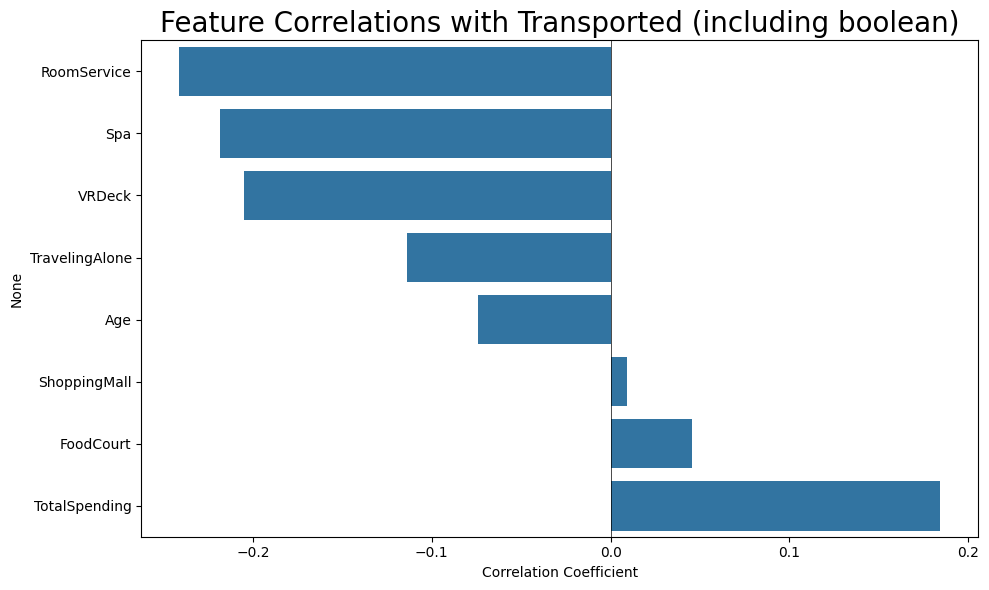

In [37]:

analysis_df = df.copy()
attributes = ['TotalSpending', 'CryoSleep', 'VIP', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'TravelingAlone']

corr_matrix = analysis_df[attributes].corr()
corr_matrix['Transported'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
# Excluding 'Transported' from the correlations
correlations = corr_matrix['Transported'].drop('Transported').sort_values(ascending=True)
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Feature Correlations with Transported (including boolean)', fontsize=20)
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

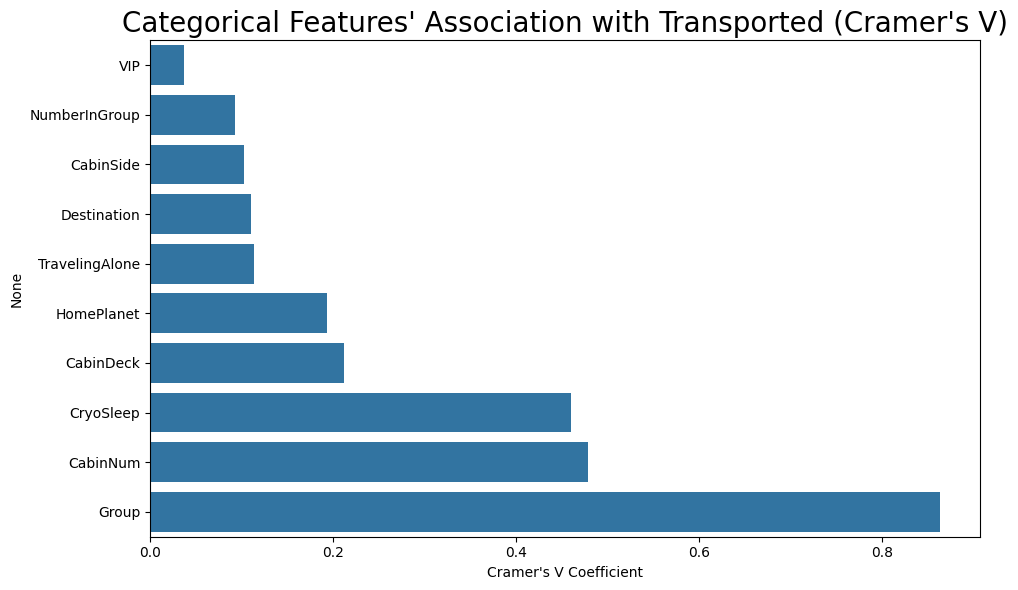

In [38]:
categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Group',
       'NumberInGroup', 'CabinDeck', 'CabinNum', 'CabinSide', 'TravelingAlone']
important_columns = {}
from scipy.stats import chi2_contingency
for column in categorical_columns:
    # Create contingency table
    contingency_table = pd.crosstab(analysis_df[column], analysis_df['Transported'])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Calculate Cramer's V for effect size
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramer_v = np.sqrt(chi2 / (n * min_dim))
    
    # Add to dictionary
    important_columns[column] = cramer_v

important_columns
cramer_v_series = pd.Series(important_columns).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=cramer_v_series.values, y=cramer_v_series.index)
plt.title("Categorical Features' Association with Transported (Cramer's V)", fontsize=20)
plt.xlabel("Cramer's V Coefficient")
plt.tight_layout()
plt.show()

In [39]:
print("Unique CabinNum values:", df['CabinNum'].nunique())
print("Unique Group values:", df['Group'].nunique())
print("CabinNum value counts:")
print(df['CabinNum'].value_counts())

print("\nGroup value counts:")
print(df['Group'].value_counts())

# Group and CabinNum seem to have weirdly high Cramer's V values, indicating a strong correlation between these variables and Transported. 
# However, it doesn't logically make sense as the group seems to be an arbitrary number and the cabin number doesn't provide much information either, the more important cabin info should be in CabinDeck and CabinSide.
# What's likely happening here is that the high number of unique categories in both are artificially inflating the correlation. 
# There are a lot of unique categories in both of those (6217 values for Group and 1817 values for CabinNum).
# This is a classic case where the cardinality of the variables is causing the statistical test to break down.
# When you have almost as many categories as observations, you're essentially creating a nearly one-to-one mapping between the category and the outcome, which artificially inflates correlation measures.

Unique CabinNum values: 1817
Unique Group values: 6217
CabinNum value counts:
0       217
82       28
86       22
19       22
97       21
       ... 
1685      1
639       1
1082      1
1689      1
1877      1
Name: CabinNum, Length: 1817, dtype: int64

Group value counts:
4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: Group, Length: 6217, dtype: int64


## Exploratory Data Analysis (EDA)

Next, we perform some basic exploratory analysis to understand the distributions of key features. We will check the distribution of age, total spending, and also look at the counts of passengers by HomePlanet. This helps us form a hypothesis for which features might be influential.

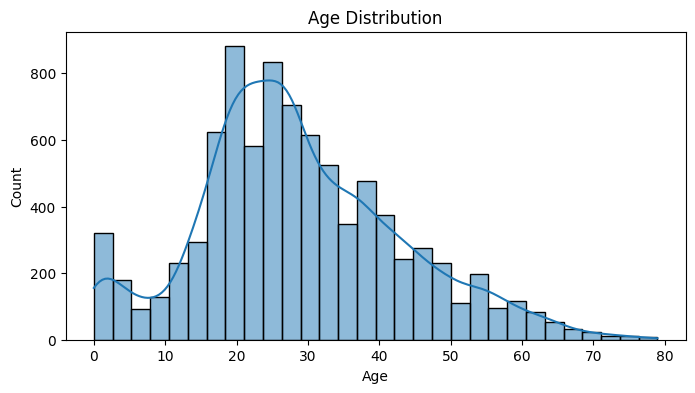

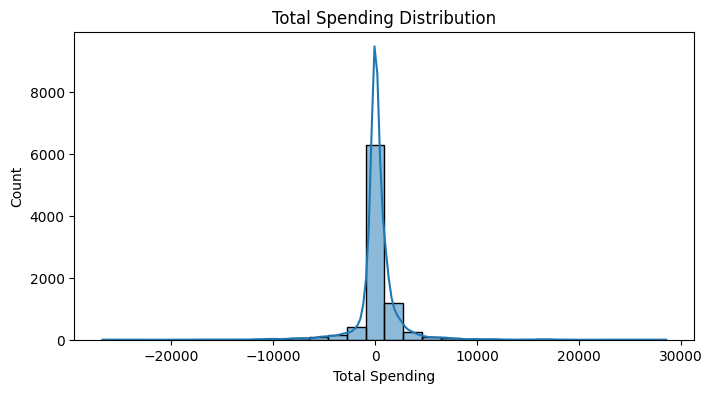

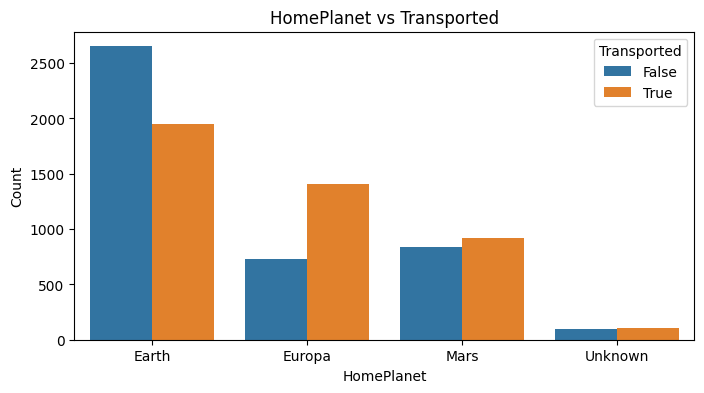

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Age
plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Distribution of Total Spending
plt.figure(figsize=(8, 4))
sns.histplot(df['TotalSpending'], bins=30, kde=True)
plt.title('Total Spending Distribution')
plt.xlabel('Total Spending')
plt.ylabel('Count')
plt.show()

# Count of HomePlanet by Transported status
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='HomePlanet', hue='Transported')
plt.title('HomePlanet vs Transported')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.show()

## Feature Engineering and Preprocessing

We now define our features and set up a preprocessing pipeline. We separate numeric and categorical features. For numeric features, we apply a power transformation to reduce skewness and scale them. For categorical features, we impute missing values and one-hot encode them.

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer

# Prepare training data features and target
X = df.drop(['Transported'], axis=1)
y = df['Transported'].astype(int)

# Define features lists
numeric_features = ['Age', 'TotalSpending', 'GroupSize', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = categorical_columns

# Build numeric and categorical transformers
numeric_transformer = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine them into a column transformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## Modeling: Logistic Regression and Random Forest 

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, random_state=42))
])

# ---- Train/Validation Split and Model Evaluation ----
# Stratify by target to keep distribution balanced.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the pipeline on the training data.
pipeline.fit(X_train, y_train)

# Predict on validation data and calculate accuracy.
y_pred = pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Cross-validation for a robust performance estimate.
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

ValueError: A given column is not a column of the dataframe

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Build a new pipeline using RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Let's evaluate our RandomForest model with 5-fold cross-validation.
rf_cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy')
print(f'Random Forest Cross-Validation Accuracy: {np.mean(rf_cv_scores):.4f} ± {np.std(rf_cv_scores):.4f}')

# Optionally, perform hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best CV Accuracy: {grid_search.best_score_:.4f}')

# Evaluate the best estimator on the validation set.
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy: {rf_val_accuracy:.4f}')

Random Forest Cross-Validation Accuracy: 0.7791 ± 0.0094
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best CV Accuracy: 0.7998
Random Forest Validation Accuracy: 0.8068


## Modeling with XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1]
}

xgb_grid = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X, y)
best_xgb = xgb_grid.best_estimator_
print("Best XGBoost parameters:", xgb_grid.best_params_)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:33:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:33:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:33:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:33:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/x

Best XGBoost parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1}


## Test Data Prediction and Submission

In [ ]:
X_test = test.drop(['PassengerId', 'Name', 'GroupID'], axis=1)
test_preds = best_xgb.predict(X_test)
test_preds_str = ['True' if p == 1 else 'False' for p in test_preds]
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': test_preds_str})
submission.to_csv('submission.csv', index=False)

# Conclusion